In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# We offer pre-filtered Google Drive files to speed up execution of this cell.

#df = pd.read_csv("user_log_format1.csv")  # SHA256: a6bc8eabc40b61a562a5e45c91e9b822418d0d863576b28a9ccd549451e55a92
#df = df[df['item_id'].isin(range(481, 640+1))]
df_user_log = pd.read_csv('https://drive.google.com/uc?id=1DwEvKOYl0hQmd2muwDa13O17smPPgn0D')
df_user_info = pd.read_csv('https://drive.google.com/uc?id=1wM9LY4rAsMLGe6GUZNQd50R8WHiH9xaf')
#df1 = pd.read_csv("user_info_format1.csv")
df2 = pd.read_csv("train_format1.csv")

# Data Visualization

In [3]:
df_user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,7254.000000,7254.000000,7254.000000,7254.000000,7248.000000,7254.000000,7254.00000
mean,212242.874414,550.680866,856.662807,2248.200441,3430.941777,918.570720,0.32327
std,123871.986646,45.550493,454.733960,1398.951493,2393.470654,196.713235,0.82503
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.00000
25%,101420.750000,517.000000,407.000000,1234.000000,1345.000000,729.000000,0.00000
50%,216374.000000,545.000000,748.000000,1923.000000,2462.000000,1006.000000,0.00000
75%,321987.000000,591.000000,1255.000000,3659.000000,5376.000000,1109.000000,0.00000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.00000


In [4]:
df_user_log.isnull().any()

user_id        False
item_id        False
cat_id         False
seller_id      False
brand_id        True
time_stamp     False
action_type    False
dtype: bool

<Axes: xlabel='action_type', ylabel='count'>

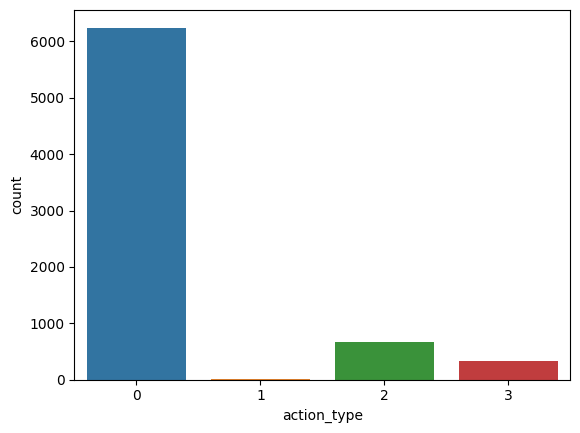

In [5]:
sns.countplot(x='action_type', data=df_user_log)

In [6]:
df_user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


<Axes: xlabel='age_range', ylabel='count'>

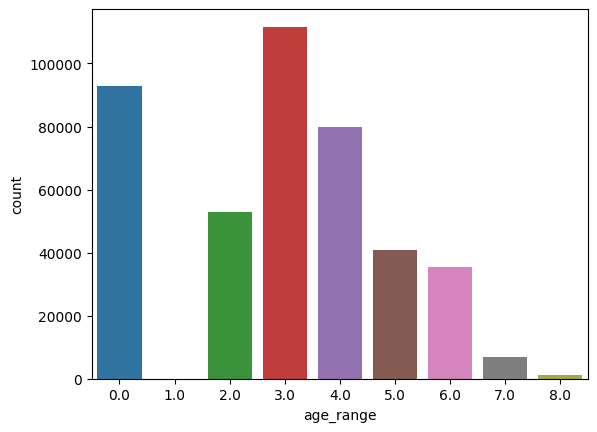

In [7]:
sns.countplot(x='age_range', data=df_user_info)

<Axes: xlabel='gender', ylabel='count'>

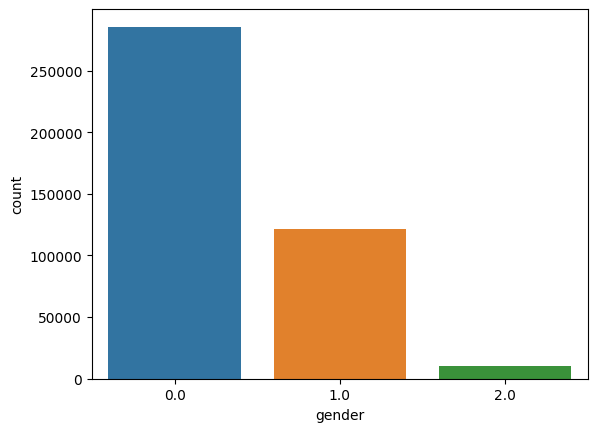

In [8]:
sns.countplot(x='gender', data=df_user_info)

# Feature Engineering
We should analyze the data more to see if we can extract more structured features.

In [9]:
merged_df = pd.merge(pd.merge(df_user_log, df_user_info, on='user_id'), df2, on='user_id')
merged_df = merged_df[merged_df.notnull().all(axis=1)]  # Remove rows with any nulls

merged_df['time_stamp'].astype('str')
merged_df['time_str'] = merged_df['time_stamp'].astype('str')
merged_df['Day'] = merged_df['time_stamp'] % 100
merged_df['Month'] = (merged_df['time_stamp'] - merged_df['Day']) / 100
merged_df['Month'] = merged_df['Month'].astype('int')
merged_df['DayOfYear'] = merged_df['Month'].apply(lambda x: sum([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31][:x])) + merged_df['Day']  # If we have to deal with leap years, I will cry
merged_df['DayOfWeek'] = merged_df['Day'] % 7

merged_df.sort_values('item_id')

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,time_str,Day,Month,DayOfYear,DayOfWeek
2253,421381,481,1331,318,4275.0,1111,0,2.0,0.0,962,0,1111,11,11,345,4
4726,376442,481,1331,318,4275.0,1016,0,2.0,0.0,4173,0,1016,16,10,320,2
2801,179767,481,1331,318,4275.0,1008,0,6.0,1.0,437,0,1008,8,10,312,1
4714,183135,481,1331,318,4275.0,821,0,5.0,0.0,1916,0,821,21,8,264,0
4713,183135,481,1331,318,4275.0,821,0,5.0,0.0,1916,0,821,21,8,264,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,109905,640,612,2246,394.0,1108,0,3.0,0.0,2928,0,1108,8,11,342,1
1260,14473,640,612,2246,394.0,923,0,6.0,0.0,3463,0,923,23,9,296,2
1850,6402,640,612,2246,394.0,1111,0,0.0,1.0,3528,0,1111,11,11,345,4
3403,16102,640,612,2246,394.0,1110,0,2.0,0.0,3288,0,1110,10,11,344,3


In [10]:
merged_df.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type,age_range,gender,merchant_id,label,Day,Month,DayOfYear,DayOfWeek
count,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000,5064.000000
mean,212851.840837,550.306477,876.033570,2141.187599,3260.981240,921.772907,0.319313,3.273894,0.343799,2431.043444,0.080174,14.960111,9.068128,290.106438,3.200829
std,122694.289306,45.255385,467.266302,1385.563428,2342.411169,195.902156,0.824361,1.814262,0.620673,1484.175273,0.271589,8.471536,1.999778,57.348899,1.720940
min,192.000000,481.000000,22.000000,2.000000,99.000000,511.000000,0.000000,0.000000,0.000000,10.000000,0.000000,1.000000,5.000000,162.000000,0.000000
25%,112534.000000,517.000000,407.000000,966.000000,1345.000000,730.000000,0.000000,3.000000,0.000000,1200.000000,0.000000,9.000000,7.000000,242.000000,2.000000
50%,217100.000000,545.000000,748.000000,1699.000000,2431.000000,1007.000000,0.000000,3.000000,0.000000,2273.000000,0.000000,11.000000,10.000000,311.000000,4.000000
75%,321643.000000,591.000000,1255.000000,3556.000000,5097.000000,1109.000000,0.000000,4.000000,1.000000,3828.000000,0.000000,24.000000,11.000000,343.000000,4.000000
max,424094.000000,640.000000,1661.000000,4994.000000,8297.000000,1111.000000,3.000000,8.000000,2.000000,4993.000000,1.000000,31.000000,11.000000,345.000000,6.000000


## Data Visualization on New Features



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='Month', ylabel='Density'>

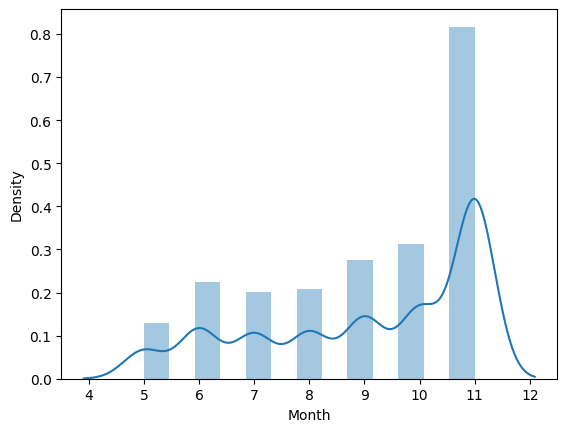

In [11]:
sns.distplot(merged_df['Month'], hist=True)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='DayOfYear', ylabel='Density'>

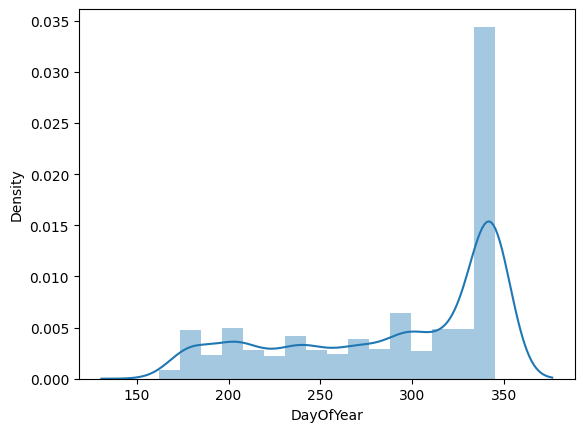

In [12]:
sns.distplot(merged_df['DayOfYear'], hist=True)

<Axes: xlabel='gender', ylabel='count'>

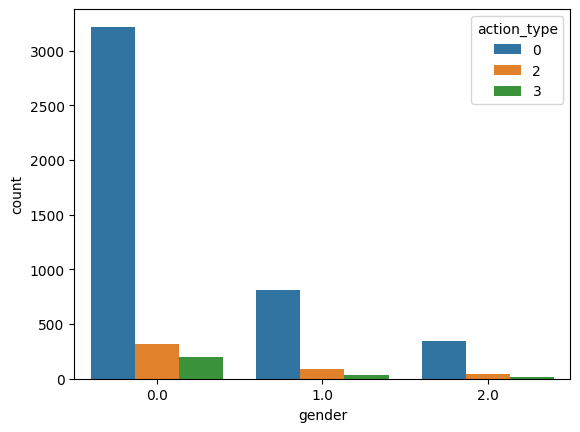

In [13]:
sns.countplot(x='gender', hue='action_type', data=merged_df)

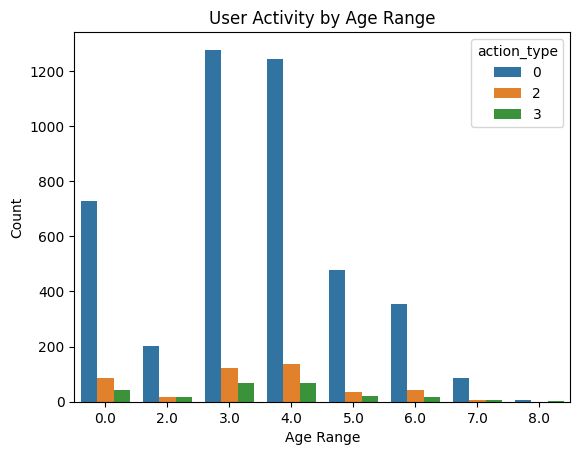

In [14]:
# create a countplot of user activity by age range
sns.countplot(x='age_range', hue='action_type', data=merged_df)
plt.title('User Activity by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

plt.show()

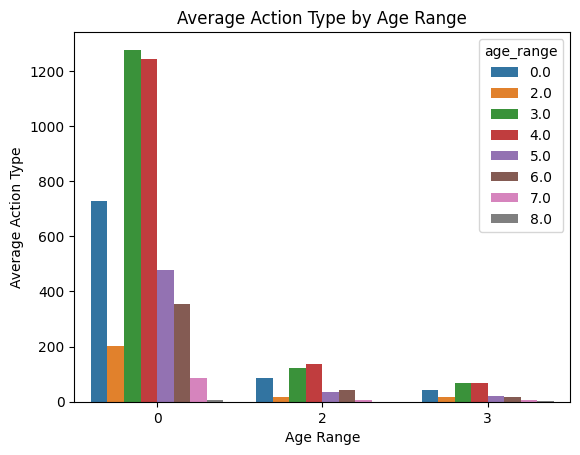

In [15]:
# create a barplot of average action type by age range
sns.countplot(x='action_type', hue='age_range', data=merged_df)
plt.title('Average Action Type by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Average Action Type')
plt.show()

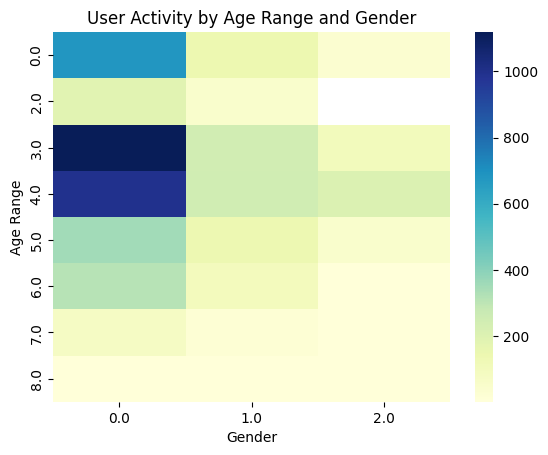

In [16]:
heatmap_df = merged_df.pivot_table(index='age_range', columns='gender', values='action_type', aggfunc='count')
sns.heatmap(heatmap_df, cmap='YlGnBu')
plt.title('User Activity by Age Range and Gender')
plt.xlabel('Gender')
plt.ylabel('Age Range')

plt.show()

# Feature Ranking
Pretty sure statistical summary is taken care by the above task.

In [17]:
# We actually want to get rid of a few columns in order to generalize a bit better.
# For starters, we expect many new users to come here, so it makes no sense on training on them.
# We also expect items to come and go, but because we're worrying about only a specific, known subset of items, we leave them.
# Categories can stay because they're almost always fixed
# Sellers, merchants, and brands should also go. They are volatile just like users.
# Timestamps should be binned, but we drop them for now. We should also bin for DayOfYear
# We hope that people buy more stuff on specific days (e.g. weekends), so we keep DayOfWeek. Same idea for months.
reduced = merged_df.copy().drop(columns=['user_id', 'seller_id', 'brand_id', 'time_stamp', 'merchant_id', 'time_str', 'DayOfYear', 'Day'])

print(reduced.shape)
X = reduced.drop(columns=['label'])
y = reduced['label']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
reduced

(5064, 8)
(5064, 7) (5064,)


,item_id,cat_id,action_type,age_range,gender,label,Month,DayOfWeek
0,568,683,0,4.0,1.0,0,11,3
1,568,683,0,4.0,1.0,0,11,3
2,489,420,0,4.0,0.0,0,7,1
3,640,612,0,5.0,0.0,0,11,4
4,495,464,2,4.0,1.0,0,10,1
...,...,...,...,...,...,...,...,...
5089,496,267,0,0.0,0.0,0,11,1
5090,496,267,0,0.0,0.0,0,11,1
5091,504,1213,0,0.0,1.0,0,10,1
5092,504,1213,0,0.0,1.0,0,10,1


In [18]:
# Let's see what works the best right out of the box
# We focus on RandomTreeClassifier for Shapley analysis
forest_reduced = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print(forest_reduced.score(X_test, y_test))

0.9230009871668312


In [19]:
pd.Series(forest_reduced.feature_importances_, index=X.columns).sort_values().tail(20)

action_type    0.047289
gender         0.072900
Month          0.138963
age_range      0.175891
cat_id         0.182148
DayOfWeek      0.189788
item_id        0.193022
dtype: float64

In [20]:
# And let's test on which one does better when we do one-hot encoding on all the categorical columns.
onehot_df = pd.get_dummies(reduced, columns=['item_id', 'cat_id', 'action_type', 'age_range', 'Month', 'DayOfWeek'])
print(onehot_df.shape)
eX = onehot_df.drop(columns=['label'])
ey = onehot_df['label']
print(eX.shape, ey.shape)
eX_train, eX_test, ey_train, ey_test = train_test_split(eX, ey, test_size=0.2, random_state=1)
onehot_df

(5064, 251)
(5064, 250) (5064,)


,gender,label,item_id_481,item_id_482,item_id_483,item_id_484,item_id_485,item_id_486,item_id_488,item_id_489,...,Month_9,Month_10,Month_11,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6
0,1.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,1.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,0.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,1.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5089,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5090,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
5091,1.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
5092,1.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0


In [21]:
forest_onehot = RandomForestClassifier(random_state=0).fit(eX_train, ey_train)
print(forest_onehot.score(eX_test, ey_test))

0.9210266535044422


In [22]:
pd.Series(forest_onehot.feature_importances_, index=eX.columns).sort_values().tail(20)

Month_6          0.018545
DayOfWeek_0      0.018565
DayOfWeek_5      0.019974
Month_9          0.020571
Month_8          0.020654
Month_7          0.021029
action_type_0    0.021074
age_range_5.0    0.021331
Month_11         0.024453
DayOfWeek_6      0.025614
Month_10         0.027383
age_range_6.0    0.028022
DayOfWeek_3      0.031016
DayOfWeek_1      0.031469
DayOfWeek_2      0.031989
DayOfWeek_4      0.033952
age_range_0.0    0.035910
age_range_3.0    0.039432
age_range_4.0    0.044329
gender           0.095586
dtype: float64

In [23]:
# Now let's do some PCA!

pca = PCA(n_components=4)
item_ids = eX.filter(like='item_id_').columns
cat_ids = eX.filter(like='cat_id_').columns
action_types = eX.filter(like='action_type_').columns
age_ranges = eX.filter(like='age_range_').columns
months = eX.filter(like='Month_').columns
dayofweeks = eX.filter(like='DayOfWeek_').columns
#print(user_ids)
onehots = ["gender"] + list(item_ids) + list(cat_ids) + list(action_types) +  list(age_ranges) + list(months) + list(dayofweeks)

pca.fit(eX[onehots])
#display([f"{_:.4f}" for _ in pca.explained_variance_ratio_][:10])
print(sum(pca.explained_variance_ratio_))

0.27960066231363034


In [24]:
forest_pca = RandomForestClassifier(random_state=0).fit(pca.transform(eX_train), ey_train)
print(forest_pca.score(pca.transform(eX_test), ey_test))
#pd.Series(forest.feature_importances_).sort_values().tail(20) # This is useless as PCA transforms dimensions that don't really have meaning

0.9239881539980257


<class 'shap.explainers._tree.Tree'>


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


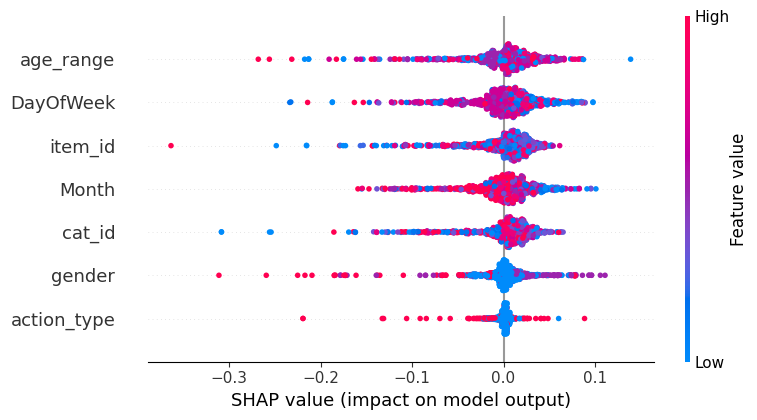

In [25]:
# Let's run Shapley analysis on forest (as running it on PCA won't give us useful results and running it on one-hot would have too many dimensions)
explainer = shap.TreeExplainer(forest_reduced)
shap_values = explainer.shap_values(X_train.head(1000))
print(type(explainer))
shap.summary_plot(shap_values[0], X_train.head(1000))

In [26]:
# This is more useful, but not nearly as much because we treat cat_id and item_id as non-categorical data.
# You can see this because the feature values don't really follow a pattern
# We can interpret age range, though. It's also a mixed bag, but we can see the center of the mass shifted rightwards, meaning that any age could influence the output more
# Day of week can also play a significant role, with most mid-week purchases not affecting the model output. Weekend and Monday purchases can positively affect the model output.
# Months can also affect. Early months have the most impact on the output, while it's harder to predict near the end of the year.
# We also see the large amount of purple to the left, indicating that middle-aged people are less likely to change the output.
# Gender is tricker as the "low" represents females and the "high" represents males. Females mostly don't influence outputs, but some men can influence output indicated by the purple mass to the right.
# Action type is normal. The "low" represents clicks (a common action) and higher values are better than clicks. Just clicks alone don't suggest anything, but any higher values (such as a person adding to the cart or purchasing it) can signfiicantly influence the results.

<Axes: >

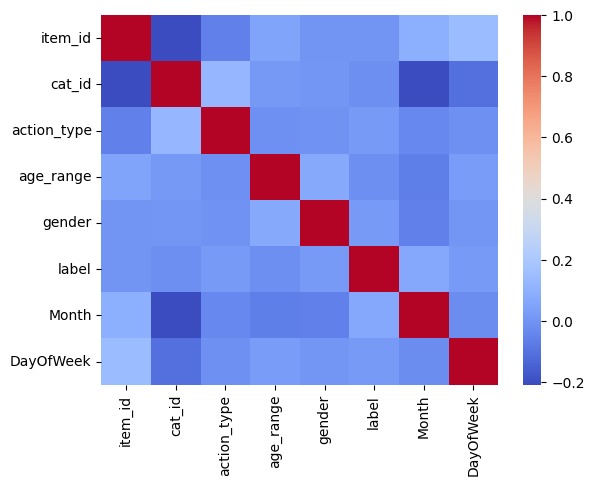

In [27]:
# Here's some correlations
# We only do correlations on reduced, as doing so on one-hot is computationally expensive to visualize (due to the many columns)
sns.heatmap(reduced.corr(), cmap='coolwarm')

<Axes: >

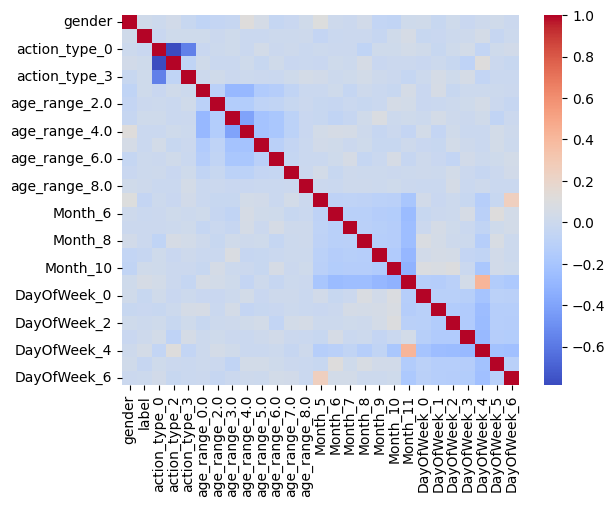

In [28]:
# If we drop item_id_ columns and cat_id_ columns, we can visualize it, although it is harder to interpret due to the poor x-axis ticks
sns.heatmap(onehot_df.drop(columns=onehot_df.filter(like='item_id_')).drop(columns=onehot_df.filter(like='cat_id_')).corr(), cmap='coolwarm')

In [29]:
# We can see that action types, age ranges, months, and days of weeks all correlate with one another, which is not that surprising

In [30]:
# Let's perform LDA
lda = LinearDiscriminantAnalysis().fit(eX_train, ey_train)
print(lda.score(eX_test, ey_test))
pd.Series(np.abs(lda.coef_[0]), index=eX.columns).sort_values().tail(20)

0.926949654491609


item_id_632    1.755895
item_id_634    1.946539
item_id_525    2.094337
cat_id_1197    2.280422
item_id_586    2.280422
item_id_598    2.680515
cat_id_1553    2.903671
item_id_555    3.165067
item_id_557    3.298308
cat_id_115     3.298308
item_id_621    3.571990
item_id_637    3.589845
cat_id_715     3.589845
item_id_509    3.764784
item_id_607    4.883715
item_id_552    6.169289
cat_id_215     6.257393
item_id_616    6.257393
item_id_627    6.448308
cat_id_302     6.448308
dtype: float64

In [31]:
# We can see that category and item ids are the most significant for LDA. What if we dropped them?
lda_dropped = LinearDiscriminantAnalysis().fit(eX_train.drop(columns=eX_train.filter(like='item_id_')).drop(columns=eX_train.filter(like='cat_id_')), ey_train)
print(lda_dropped.score(eX_test.drop(columns=eX_test.filter(like='item_id_')).drop(columns=eX_test.filter(like='cat_id_')), ey_test))
pd.Series(np.abs(lda_dropped.coef_[0]), index=eX_test.drop(columns=eX_test.filter(like='item_id_')).drop(columns=eX_test.filter(like='cat_id_')).columns).sort_values().tail(20)

0.930898321816387


age_range_3.0    0.094274
Month_8          0.094587
age_range_5.0    0.105426
DayOfWeek_6      0.108748
DayOfWeek_3      0.127350
action_type_0    0.127955
DayOfWeek_1      0.135500
age_range_0.0    0.152955
DayOfWeek_4      0.165944
age_range_7.0    0.165987
Month_11         0.197110
age_range_2.0    0.200710
gender           0.216850
Month_10         0.228046
DayOfWeek_5      0.239051
Month_9          0.244046
action_type_3    0.259852
DayOfWeek_0      0.427629
Month_5          0.779906
age_range_8.0    0.790227
dtype: float64

In [32]:
# We actually perform better and see that we get more splayed results than RandomTreeClassifier
# What if we do it on the reduced dataset before one-hot?
lda_reduced = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train)
print(lda_reduced.score(X_test, y_test))
pd.Series(np.abs(lda_reduced.coef_[0]), index=X.columns).sort_values().tail(20)

0.930898321816387


cat_id         0.000018
item_id        0.000726
age_range      0.038643
DayOfWeek      0.054575
Month          0.111897
action_type    0.116601
gender         0.195538
dtype: float64

<Axes: >

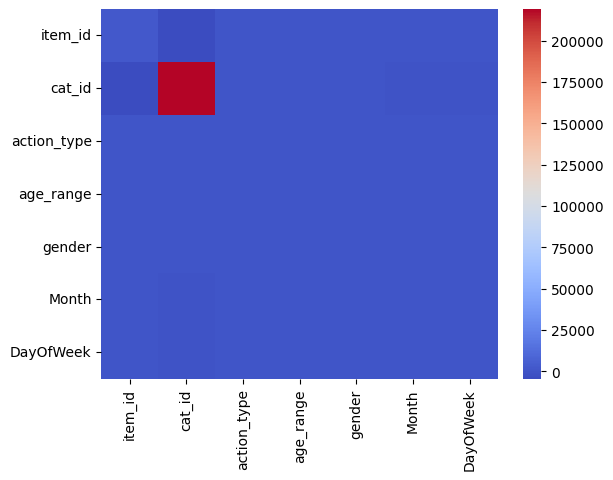

In [33]:
# Gender, action type, and month are most significant for LDA
sns.heatmap(lda_reduced.covariance_, cmap='coolwarm', xticklabels=X.columns, yticklabels=X.columns)

0.930898321816387
age_range      0.039510
DayOfWeek      0.052477
Month          0.111037
action_type    0.117469
gender         0.195647
dtype: float64


<Axes: >

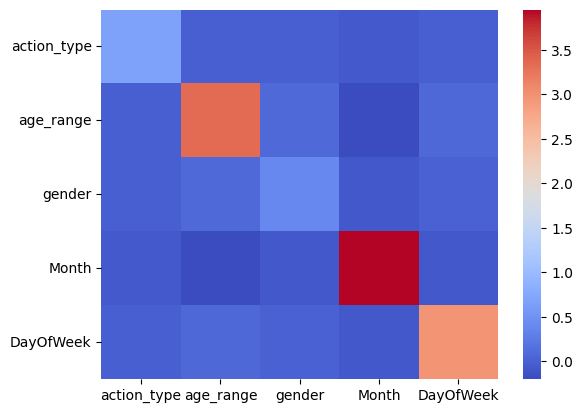

In [34]:
# Despite it being so insignificant, categories' covariance is extremely high with one another. What if we drop cat_id and item_id?
lda_reduced_dropped = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train.drop(columns=['item_id', 'cat_id']), y_train)
print(lda_reduced_dropped.score(X_test.drop(columns=['item_id', 'cat_id']), y_test))
print(pd.Series(np.abs(lda_reduced_dropped.coef_[0]), index=X.drop(columns=['item_id', 'cat_id']).columns).sort_values().tail(20))
sns.heatmap(lda_reduced_dropped.covariance_, cmap='coolwarm', xticklabels=X.drop(columns=['item_id', 'cat_id']).columns, yticklabels=X.drop(columns=['item_id', 'cat_id']).columns)

# Prediction Model
In addition to the Random Forest, PCA, and LDA above, we include a naive Bayes classifier and non-parametric techniques.

In [35]:
# We assume the data is normally distributed
bayes = GaussianNB().fit(X_train, y_train)
print(bayes.score(X_test, y_test))
# No difference if we drop the item_id and cat_id columns
bayes_reduced = GaussianNB().fit(X_train.drop(columns=['item_id', 'cat_id']), y_train)
print(bayes_reduced.score(X_test.drop(columns=['item_id', 'cat_id']), y_test))

# Note that Gaussian Naive Bayes fails hard on one-hot encoding!
bayes_onehot = GaussianNB().fit(eX_train, ey_train)
print(bayes_onehot.score(eX_test, ey_test))

0.9318854886475815
0.9318854886475815
0.1727541954590326


In [36]:
# Why? Because we're not using the right one!
bernoulli = BernoulliNB().fit(eX_train, ey_train)
print(bernoulli.score(eX_test, ey_test))

0.9259624876604146


In [37]:
# If we drop item and category IDs?
bernoulli_dropped = BernoulliNB().fit(eX_train.drop(columns=eX_train.filter(like='item_id_')).drop(columns=eX_train.filter(like='cat_id_')), ey_train)
print(bernoulli_dropped.score(eX_test.drop(columns=eX_test.filter(like='item_id_')).drop(columns=eX_test.filter(like='cat_id_')), ey_test))

0.930898321816387


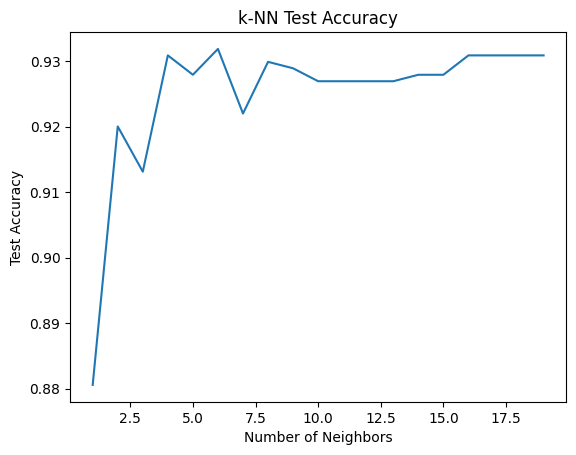

6 0.9318854886475815


In [38]:
# Let's move to kNN. Let's determine which k value is the best.
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.plot(k_range, scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax(scores)], np.max(scores))

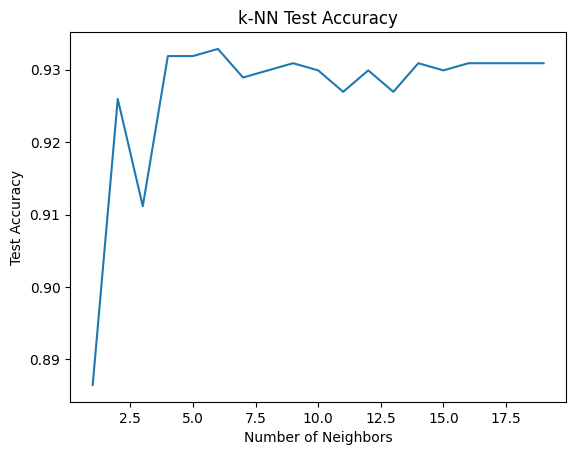

6 0.932872655478776


In [39]:
# It appears that k=6 is the best. Does this apply to one-hot?
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k).fit(eX_train, ey_train)
    scores.append(knn.score(eX_test, ey_test))
plt.plot(k_range, scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(k_range[np.argmax(scores)], np.max(scores))

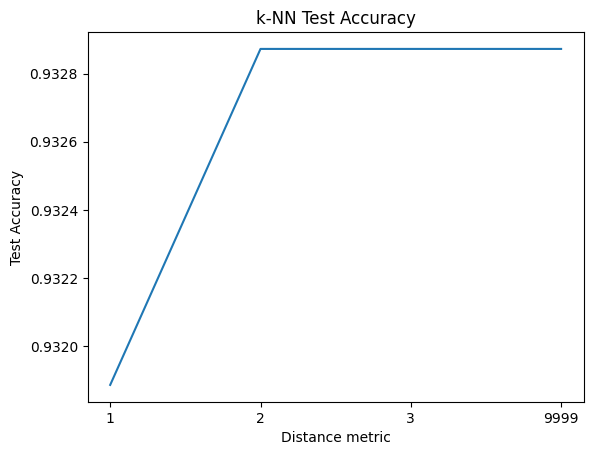

2 0.932872655478776


In [40]:
# Yes. Unlike other models, one-hot encoding actually performs better.
# Using k=6, does different distance measures mark it better?
p_range = [1, 2, 3, 9999] # 9999 represents Linf
scores = []
for p in p_range:
    knn = KNeighborsClassifier(n_neighbors=6, p=p).fit(eX_train, ey_train)
    scores.append(knn.score(eX_test, ey_test))
plt.plot([1, 2, 3, 4], scores)
plt.xticks([1, 2, 3, 4], p_range)
plt.xlabel('Distance metric')
plt.ylabel('Test Accuracy')
plt.title('k-NN Test Accuracy')
plt.show()
print(p_range[np.argmax(scores)], np.max(scores))

# Model Evaluation
Let's do this once we're happy with all our models